In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

In [2]:
main_df = pd.read_csv('./Data/main.csv')
main_df.head(3)

,progress_id,module_number,lesson_number,status,start_date,finish_date,student_id,course_id,course_title,course_field,module_title,lesson_title,lesson_token,is_video,is_homework
0,a387ab916f402cb3fbfffd29f68fd0ce,2,4,done,2018-06-23 08:28:50.681065+00,2018-06-23 08:28:52.439542+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False
1,3b9dce04f32da32763124602557f92a3,2,4,done,2019-03-18 14:23:17.328374+00,2019-03-18 14:54:50.979612+00,03151bc73bdb29fe1be1443c6d83e22f,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False
2,73e17a05355852fe65b785c82c37d1ad,2,4,done,2019-07-09 09:18:46.19862+00,2019-07-11 08:03:09.222385+00,ed235f47e16da6e83d3f1cb511f38ea6,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False


In [3]:
hw_df = main_df[main_df['is_homework'] == True] # только ДЗ

##  Метрика успеваемости 


Иногда студенты берут курсы, которые оказываются для них неподъемными. 
* Это может быть как по причинам недостаточной изначальной подготовки, - это если стоп на начальных модулях
* так и по причинам, связанным с низкой мотивацией студента. - это если стоп после середины
* Для улучшения качества контента надо выявить причину. 
* Нужна метрика успеваемости студента.
* Нужен список таких студентов на каждом курсе, чтобы предоставить продюсерам список проблемных студентов.

### Влияние возраста на  время прохождения курса

In [4]:
hw_done_df = main_df[(main_df['is_homework'] == True)&(~main_df['finish_date'].isna())] # только выполненные ДЗ 

In [5]:
age_df = pd.read_csv('./Data/age.csv')
age_df.head(3)

,course_id,course_title,progress_id,student_id,city,birthday,age
0,943306102e5b067d08a29094f37b8193,Java-разработчик c нуля,45cdf025b87db75e84f93c4ac3ccb5c7,0b4656b84ca60350583f8fbe236dda86,Москва,1997-07-24,24
1,6e4837f0a65c68efbfdd0594d6774701,Java-разработчик,aab2812adb6f8636341b11b693c44a22,0b4656b84ca60350583f8fbe236dda86,Москва,1997-07-24,24
2,943306102e5b067d08a29094f37b8193,Java-разработчик c нуля,0c56109dde49080e7441e95b22bb73c2,1d874e6b6bdc34559781f65f9f761791,Рязань,1990-08-08,31


In [6]:
# в каждом курсе для каждого студента нашли минимальную дату начала ДЗ и максимальную дату окончания ДЗ

hw_done_df = \
hw_done_df.groupby(['course_title', 'student_id']).agg({'start_date' : 'min', 'finish_date' : 'max'}).reset_index()

In [7]:
# нашли время прохождения студентом курса

hw_done_df['days_number'] = \
hw_done_df.apply(lambda x: len(pd.date_range(start=x['start_date'], end=x['finish_date'], freq='D')), axis=1)

In [8]:
hw_done_df = age_df[['course_title', 'student_id', 'age']]\
.merge(hw_done_df[['course_title', 'student_id', 'days_number']], how='right', on=['course_title', 'student_id'])
# объединили чтобы связать возраст и срок прохождения курса

hw_done_df.dropna(inplace=True)

In [9]:
# разбили на диапазоны по возрасту

bins = [0, 25, 35, 45, 55, 65]
hw_done_df['range'] = pd.cut(hw_done_df['age'], bins=bins, labels=['18-25', '26-35', '36-45', '46-55', '56-65'])

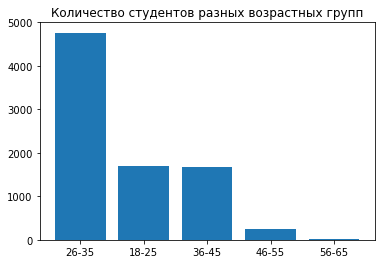

In [10]:
plt.bar(hw_done_df['range'].value_counts().index, hw_done_df['range'].value_counts().values)
plt.title('Количество студентов разных возрастных групп')
plt.show()

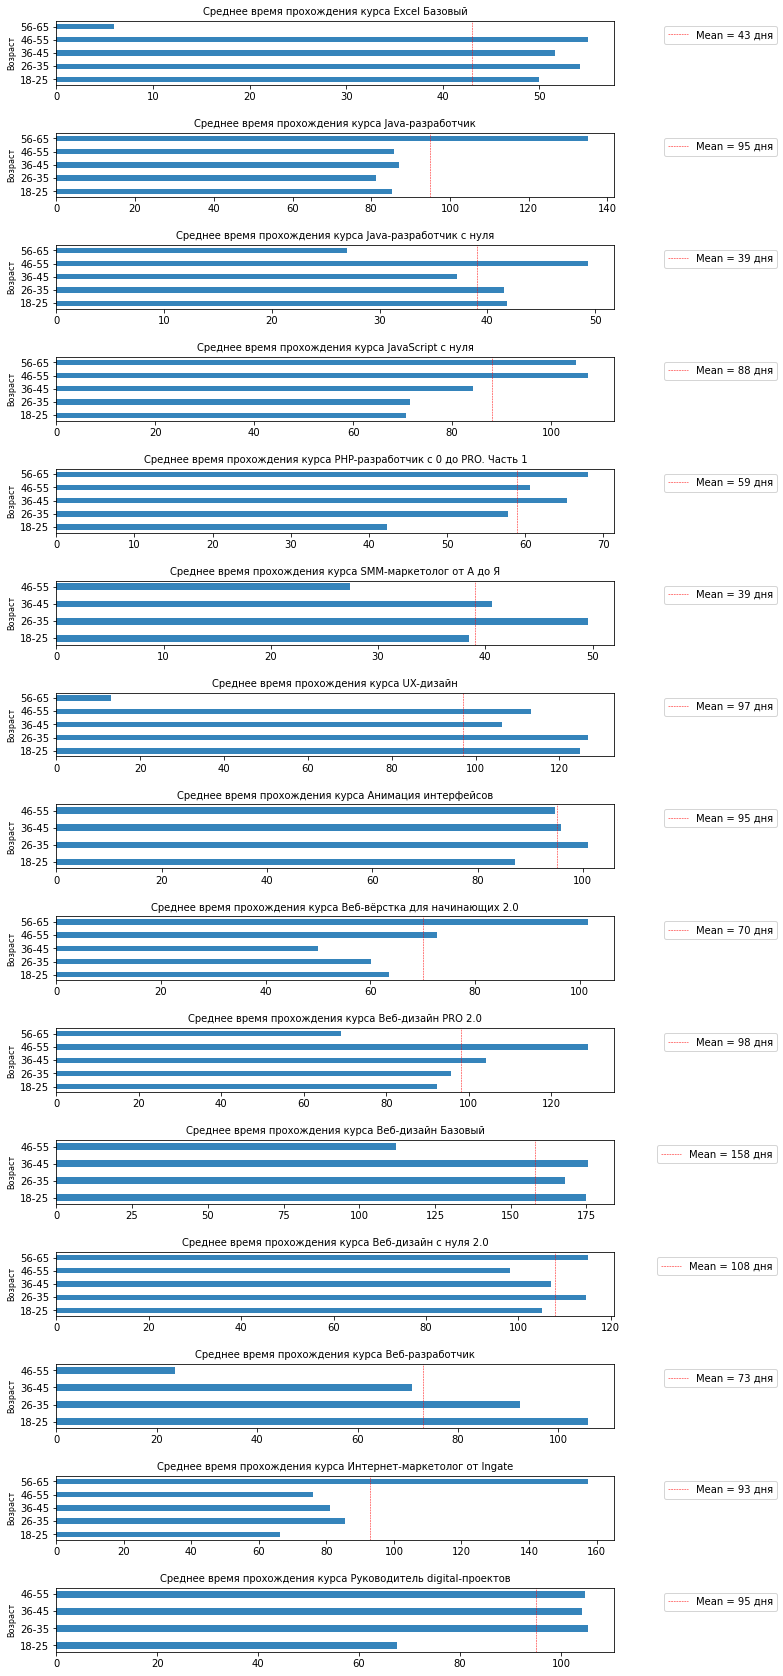

In [11]:
qaz_df = hw_done_df.groupby(['course_title', 'range']).days_number.mean().reset_index()

fig, axs = plt.subplots(15, 1, figsize=(10,30))  
fig.subplots_adjust(hspace=0.75)

i=0
for name, group in qaz_df.groupby('course_title'):
    mean_value = round(group['days_number'].mean())
    axs[i].barh(group['range'], group['days_number'], height=0.4, alpha=0.9)
    axs[i].set_ylabel('Возраст', fontsize = 8)
    axs[i].set_title('Среднее время прохождения курса'+' '+ name, fontsize=10)        
    axs[i].axvline(mean_value, ls='--', color='r', label=f"Mean = {mean_value} дня", linewidth=0.5)
    axs[i].legend()
    axs[i].legend(bbox_to_anchor=(1.3,1))
        
    i+=1

plt.show()

### Выводы: 

### Найдем тех кто необычно долго проходили курс

* Если величина в пределах 2 сигм - то это более 95% значений.

In [12]:
hw_done_df['std'] = hw_done_df.groupby('course_title')['days_number'].transform('std') # Стандартное отклонение
hw_done_df['mean'] = hw_done_df.groupby('course_title')['days_number'].transform('mean') # Среднее значение
hw_done_df['2_dev'] = (hw_done_df['days_number'] - hw_done_df['mean']).abs() > 2*hw_done_df['std'] # 4,56%

In [13]:
bad_df = hw_done_df[hw_done_df['2_dev'] == True].groupby('course_title')['student_id'].unique()

# Это те, на кого точно стоило обратить внимание - долго проходили курс, но они уже закончили курсы

### Найдем тех кто проходил 3 начальные ДЗ дольше 2 сигм и еще не закончил курс

In [14]:
baza_df = main_df[(main_df['is_homework'] == True)]

# только ДЗ по всем модулям и курсам
# нельзя выбрать только первые 3 модуля, потому что неизвестно где находятся первые 3 ДЗ, поэтому берем весь датасет

In [15]:
baza_df['hw_done'] = np.where(baza_df['status'] == 'done', True, False)
# сделано ДЗ или нет

In [16]:
baza_df['course_done'] = baza_df.groupby(['course_title', 'student_id'])['hw_done'].transform(all)
# сделан курс или нет

In [17]:
course_done_df = baza_df[baza_df['course_done'] == True] # закончили уже курс
course_not_done_df = baza_df[baza_df['course_done'] == False]# не закончили курс

### Найдем базовые показатели по тем кто уже ЗАКОНЧИЛ курс

In [18]:
course_done_df = course_done_df.sort_values('start_date').groupby(['course_title', 'student_id']).head(3)
# только 3 первых выполненных ДЗ на курсе

In [19]:
course_done_df = course_done_df.groupby(['course_title', 'student_id']).\
agg({'start_date' : 'min', 'finish_date' : 'max'}).reset_index()
# в каждом курсе для первых 3 ДЗ для каждого студента нашли минимальную дату начала ДЗ и максимальную дату окончания ДЗ

course_done_df['days_number'] = \
course_done_df.apply(lambda x: len(pd.date_range(start=x['start_date'], end=x['finish_date'], freq='D')), axis=1)
# нашли время прохождения студентом первых 3 ДЗ

In [20]:
course_done_df['std'] = course_done_df.groupby(['course_title'])['days_number'].transform('std')
course_done_df['mean'] = course_done_df.groupby(['course_title'])['days_number'].transform('mean')
course_done_df['2_dev'] = (course_done_df['days_number'] - course_done_df['mean']).abs() > 2*course_done_df['std'] 

# ст.отклонение, среднее время выполнения и те кто делал долго, но все-же закончил курс, поэтому нам не интересны
# но нам интересно будет далее course_done_df['std']

найдем тех кто делал долго первые 3 ДЗ, но еще не закончил курс и поэтому имеет смысл на них обратить внимание
для начала отбросим тех, кто вероятно бросил обучение, и тех, кто только начал и по ним недостаточно информации, для этого уберем Nan из даты окончания урока и тех у кого мене 3 выполненных ДЗ

In [21]:
course_not_done_df = course_not_done_df[course_not_done_df['status'] == 'done']
# только сделанные ДЗ

In [22]:
course_not_done_df = course_not_done_df.sort_values('start_date').groupby(['course_title', 'student_id']).head(3)
# только 3 первых выполненных ДЗ на курсе

In [23]:
student_3hw_df = (course_not_done_df.groupby('student_id').size()).reset_index()
student_3hw_df.rename(columns={0 : 'hw_number'}, inplace = True)
# подсчитали сколько ДЗ сделано студентом на курсе

In [24]:
course_not_done_df = course_not_done_df.merge(student_3hw_df, how = 'left', on = 'student_id')

In [25]:
course_not_done_df = course_not_done_df[course_not_done_df['hw_number'] >= 3]
# оставили только студентов с 3 и более выполненными ДЗ

In [26]:
course_not_done_df = course_not_done_df.groupby(['course_title', 'student_id']).\
agg({'start_date' : 'min', 'finish_date' : 'max'}).reset_index()
# в каждом курсе для первых 3 ДЗ для каждого студента нашли минимальную дату начала ДЗ и максимальную дату окончания ДЗ

course_not_done_df['days_number'] = \
course_not_done_df.apply(lambda x: len(pd.date_range(start=x['start_date'], end=x['finish_date'], freq='D')), axis=1)
# нашли время прохождения студентом первых 3 ДЗ

In [27]:
course_not_done_df['mean'] = course_not_done_df.groupby(['course_title'])['days_number'].transform('mean') # среднее

In [28]:
course_not_done_df.shape

(4149, 6)

In [29]:
course_not_done_df.merge(course_done_df[['course_title', 'student_id', 'std']],\
                on=['course_title', 'student_id'], how='left').shape

(4149, 7)

In [30]:
### данные из course_done_df['std']

course_not_done_df = course_not_done_df.merge(course_done_df[['course_title', 'std']], on='course_title', how='left')
course_not_done_df.drop_duplicates(subset=['course_title', 'student_id'], inplace=True)

In [31]:
course_not_done_df['2_dev'] = (course_not_done_df['days_number'] - course_not_done_df['mean']).abs() >\
2*course_not_done_df['std'] 

# нашли тех кто делал долго, основываясь на данных для студентов, которые уже закончили курс

In [32]:
problem_students_df = \
course_not_done_df[course_not_done_df['2_dev'] == True].groupby('course_title')['student_id'].unique().reset_index()

# список проблемных студентов по курсам

In [33]:
problem_students_df.head()

,course_title,student_id
0,Excel Базовый,"[44638f2eb49af321dc9a6042a02efdbf, 58982b4f04e..."
1,Java-разработчик,"[04ba196254f775ff03aaee0aa6525c02, 0ef971b31e9..."
2,Java-разработчик c нуля,"[1776778af511c0edeb963ada108cb00c, 30f62d18252..."
3,JavaScript с нуля,"[088bffa382a6511117aada65d880bd98, 1360b92c2dc..."
4,PHP-разработчик с 0 до PRO. Часть 1,"[0c6d89c951249b5ef1a2fafc2bf38af2, 1bd250b6d47..."
